# Identify differentially accessible regions

This tutorial assumes you have read the [Standard Pipeline](https://kzhang.org/SnapATAC2/tutorials/pbmc.html) tutorial and have finished preprocessing, clustering and cell annotations.

In [1]:
import snapatac2 as snap
import numpy as np
import polars as pl

snap.__version__

'2.3.0.dev4'

First let's load the previously processed h5ad file.

In [2]:
data = snap.read(snap.datasets.pbmc5k(type="annotated_h5ad"))
data

Updating file 'atac_pbmc_5k_annotated.h5ad' from 'https://osf.io/download/rvwhf/' to '/home/kaizhang/.cache/snapatac2'.


AnnData object with n_obs x n_vars = 4436 x 6062095 backed at '/home/kaizhang/.cache/snapatac2/atac_pbmc_5k_annotated.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'leiden', 'cell_type'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'cell_type_colors', 'reference_sequences', 'leiden_colors', 'scrublet_sim_doublet_score'
    obsm: 'X_spectral', 'X_umap', 'insertion'
    obsp: 'distances'

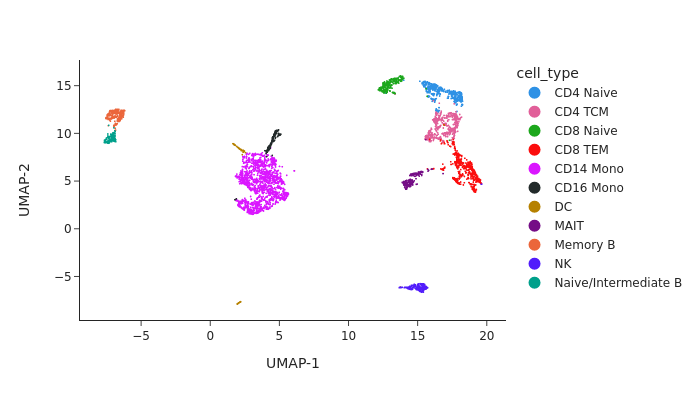

In [3]:
snap.pl.umap(data, color='cell_type', width=700, interactive=False)

## Peak calling at the cluster-level

An important goal of single-cell ATAC-seq analysis is to identify genomic regions that are enriched with TN5 insertions, or “open chromatin” regions. Using `snap.tl.call_peaks`, we can easily identify open chromatin regions in different cell populations stratified by provided group information.

In [4]:
%%time
snap.tl.call_peaks(data, groupby='cell_type')

2023-04-13 14:49:04 - INFO - Exporting data...
2023-04-13 14:54:33 - INFO - Calling peaks for 11 groups ...
2023-04-13 15:09:47 - INFO - Merging peaks...


CPU times: user 5min 50s, sys: 11.6 s, total: 6min 2s
Wall time: 20min 45s


`snap.tl.call_peaks` first calls peaks for individual groups and then merges overlapping peaks to create a list of fix-width non-overlapping peaks. The intermediate results are discarded by default but can be saved using the `out_dir` parameter.

Results of peak calling are stored in `data.uns['peaks']` as a dataframe. Rows are merged peaks, and columns are cell clusters. Boolean values in the dataframe indicate whether a peak is present in a given cell cluster.

In [5]:
data.uns['peaks'].head()

shape: (5, 12)
┌──────────────┬───────────┬───────────┬──────────────┬─────┬──────────┬───────────┬───────┬───────┐
│ Peaks        ┆ CD4 Naive ┆ CD8 Naive ┆ Naive/Interm ┆ ... ┆ Memory B ┆ CD16 Mono ┆ NK    ┆ DC    │
│ ---          ┆ ---       ┆ ---       ┆ ediate B     ┆     ┆ ---      ┆ ---       ┆ ---   ┆ ---   │
│ str          ┆ bool      ┆ bool      ┆ ---          ┆     ┆ bool     ┆ bool      ┆ bool  ┆ bool  │
│              ┆           ┆           ┆ bool         ┆     ┆          ┆           ┆       ┆       │
╞══════════════╪═══════════╪═══════════╪══════════════╪═════╪══════════╪═══════════╪═══════╪═══════╡
│ chr1:180653- ┆ false     ┆ false     ┆ false        ┆ ... ┆ false    ┆ false     ┆ true  ┆ false │
│ 181154       ┆           ┆           ┆              ┆     ┆          ┆           ┆       ┆       │
│ chr1:191594- ┆ false     ┆ false     ┆ false        ┆ ... ┆ false    ┆ false     ┆ true  ┆ false │
│ 192095       ┆           ┆           ┆              ┆     ┆          ┆           ┆       ┆       │
│ chr1:267749- ┆ false     ┆ false     ┆ false        ┆ ... ┆ false    ┆ false     ┆ false ┆ true  │
│ 268250       ┆           ┆           ┆              ┆     ┆          ┆           ┆       ┆       │
│ chr1:280500- ┆ false     ┆ false     ┆ false        ┆ ... ┆ false    ┆ false     ┆ false ┆ false │
│ 281001       ┆           ┆           ┆              ┆     ┆          ┆           ┆       ┆       │
│ chr1:585944- ┆ false     ┆ false     ┆ true         ┆ ... ┆ false    ┆ false     ┆ false ┆ false │
│ 586445       ┆           ┆           ┆              ┆     ┆          ┆           ┆       ┆       │
└──────────────┴───────────┴───────────┴──────────────┴─────┴──────────┴───────────┴───────┴───────┘

Now, with the peak list, we can create a cell by peak matrix by `snap.pp.make_peak_matrix`.

In [6]:
%%time
peak_mat = snap.pp.make_peak_matrix(data, file="peak_matrix.h5ad")
peak_mat

CPU times: user 1min 22s, sys: 1.43 s, total: 1min 24s
Wall time: 12.7 s


AnnData object with n_obs x n_vars = 4436 x 250241 backed at 'peak_matrix.h5ad'
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'leiden', 'cell_type'

Finding marker regions
---------------------------

In this section, we are going to use a quick-and-dirty method to identify marker regions for each cell type. The `tl.marker_regions` function aggregates signal across cells and utilizes z-scores to identify specifically enriched peaks.

In [7]:
%%time
marker_peaks = snap.tl.marker_regions(peak_mat, groupby='cell_type', pvalue=0.01)

/projects/ps-renlab2/kai/dev/snapatac2/snapatac2-python/snapatac2/tools/_misc.py:82: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



CPU times: user 6.56 s, sys: 499 ms, total: 7.06 s
Wall time: 7.05 s


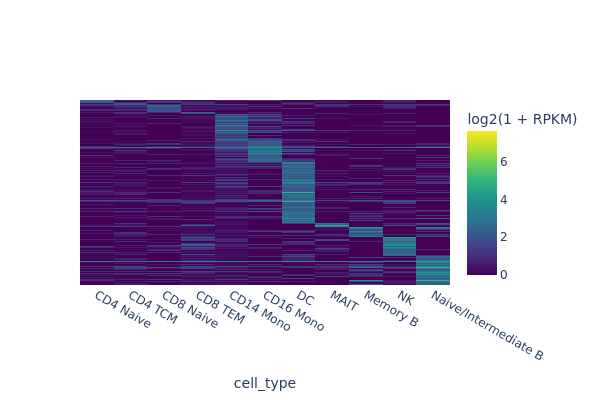

In [8]:
snap.pl.regions(peak_mat, groupby='cell_type', peaks=marker_peaks, interactive=False)

In [9]:
%%time
motifs = snap.tl.motif_enrichment(
    motifs=snap.datasets.cis_bp(unique=True),
    regions=marker_peaks,
    genome_fasta=snap.genome.hg38,
)

2023-04-13 15:10:19 - INFO - Fetching 58945 sequences ...
2023-04-13 15:10:21 - INFO - Computing enrichment ...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1165/1165 [05:42<00:00,  3.40it/s]


CPU times: user 2h 3min 58s, sys: 17.1 s, total: 2h 4min 15s
Wall time: 6min 24s


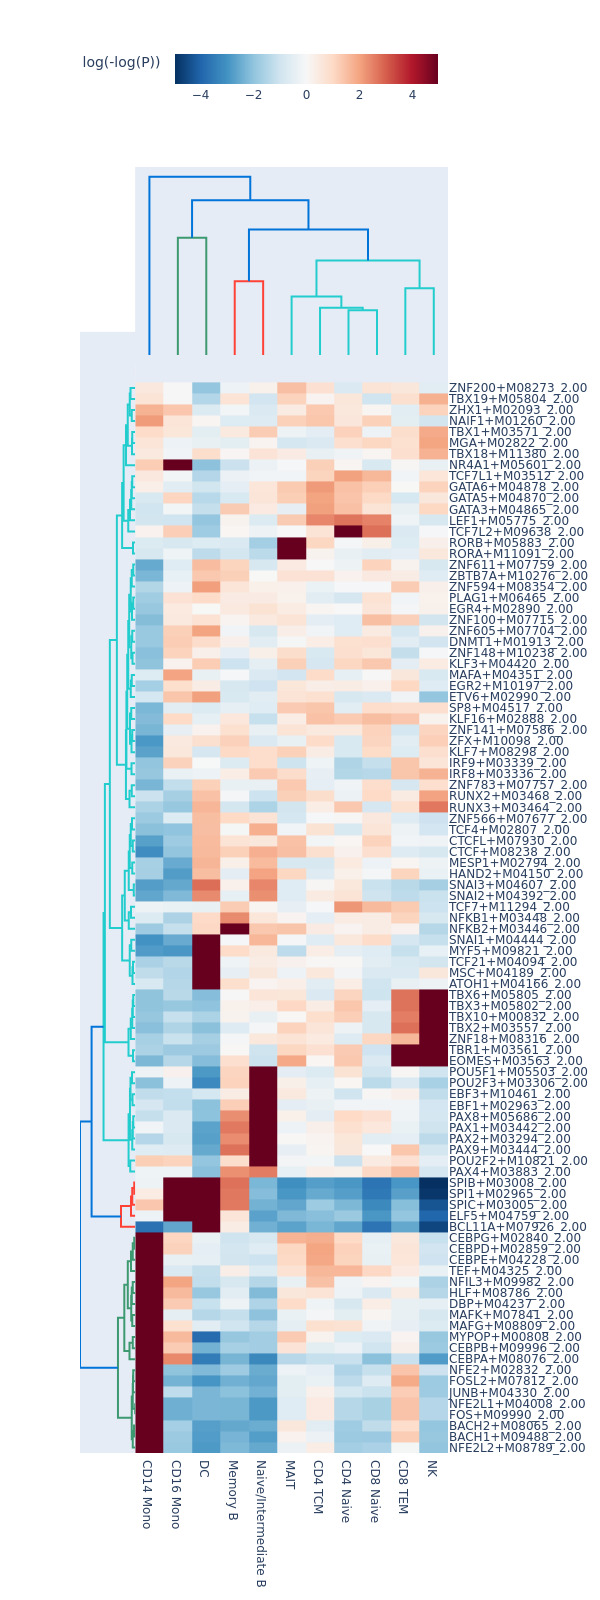

In [10]:
snap.pl.motif_enrichment(motifs, max_fdr=0.0001, height=1600, interactive=False)

## Regression-based differential test


The `tl.marker_regions` above does not consider the variations across cells. To fully utilize the single-cell information, we can apply regression-based differential test method. First, Let's select the peaks that are either present in naive B cells or memory B cells.

In [11]:
group1 = "Naive/Intermediate B"
group2 = "Memory B"
naive_B = data.obs['cell_type'] == group1
memory_B = data.obs['cell_type'] == group2
peaks_selected = np.logical_or(
    data.uns["peaks"][group1].to_numpy(),
    data.uns["peaks"][group2].to_numpy(),
)

Perform differential test using `tl.diff_test`.

In [12]:
%%time
diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1=naive_B,
    cell_group2=memory_B,
    features=peaks_selected,
)

2023-04-13 15:16:48 - INFO - Input contains 107629 features, now perform filtering with 'min_log_fc = 0.25' and 'min_pct = 0.05' ...
2023-04-13 15:17:02 - INFO - Testing 33352 features ...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33352/33352 [05:01<00:00, 110.59it/s]


CPU times: user 5min 16s, sys: 2.17 s, total: 5min 18s
Wall time: 5min 18s


Filter the results based on adjusted p-value or FDR.

In [13]:
diff_peaks = diff_peaks.filter(pl.col('adjusted p-value') < 0.01)
diff_peaks.head()

shape: (5, 4)
┌──────────────────────────┬───────────────────┬────────────┬──────────────────┐
│ feature name             ┆ log2(fold_change) ┆ p-value    ┆ adjusted p-value │
│ ---                      ┆ ---               ┆ ---        ┆ ---              │
│ str                      ┆ f64               ┆ f64        ┆ f64              │
╞══════════════════════════╪═══════════════════╪════════════╪══════════════════╡
│ chr17:3558489-3558990    ┆ 6.417912          ┆ 1.0078e-30 ┆ 3.3612e-26       │
│ chr5:156402576-156403077 ┆ 4.204133          ┆ 4.0689e-23 ┆ 6.7853e-19       │
│ chr6:52497600-52498101   ┆ 5.489535          ┆ 8.6097e-23 ┆ 9.5717e-19       │
│ chr4:155758703-155759204 ┆ -3.053255         ┆ 3.1618e-21 ┆ 2.6363e-17       │
│ chr1:15949531-15950032   ┆ 4.236554          ┆ 4.2257e-20 ┆ 2.8187e-16       │
└──────────────────────────┴───────────────────┴────────────┴──────────────────┘

/projects/ps-renlab2/kai/dev/snapatac2/snapatac2-python/snapatac2/tools/_misc.py:82: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



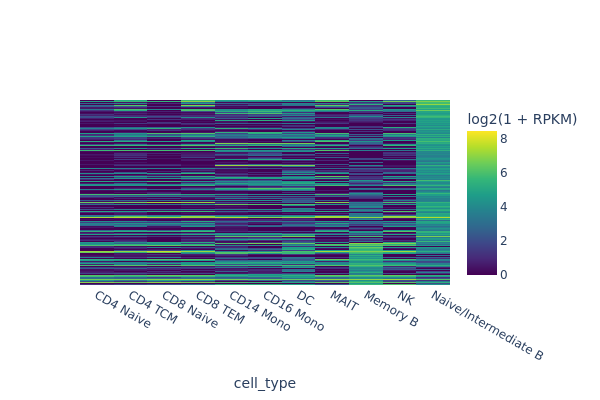

In [14]:
snap.pl.regions(
    peak_mat,
    groupby = 'cell_type',
    peaks = {
        group1: diff_peaks.filter(pl.col("log2(fold_change)") > 0)['feature name'].to_numpy(),
        group2: diff_peaks.filter(pl.col("log2(fold_change)") < 0)['feature name'].to_numpy(),
    },
    interactive = False,
)

In the next example we are going to identify peaks that are accessible in memory B cells but not in the rest of cells. One way of doing this is to select random cells from each cluster to form the background, and then perform test between memory B cells and the background.

Here we randomly select 50 cells from other cell clusters, and set the `direction = "positive"` because we are interested in peaks that are more accessible in memory B cells.

In [15]:
barcodes = np.array(data.obs_names)
background = []
for i in np.unique(data.obs['leiden']):
    if i != group2:
        cells = np.random.choice(
            barcodes[data.obs['leiden'] == i],
            size = 50,
            replace = False,
        )
        background.append(cells)
background = np.concatenate(background)

In [16]:
diff_peaks = snap.tl.diff_test(
    peak_mat,
    cell_group1 = memory_B,
    cell_group2 = background,
    features = data.uns["peaks"][group2].to_numpy(),
    direction = "positive",
)

2023-04-13 15:22:14 - INFO - Input contains 83417 features, now perform filtering with 'min_log_fc = 0.25' and 'min_pct = 0.05' ...
2023-04-13 15:22:25 - INFO - Testing 18700 features ...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18700/18700 [03:11<00:00, 97.69it/s]


In [17]:
diff_peaks = diff_peaks.filter(pl.col('adjusted p-value') < 0.01)
diff_peaks.head()

shape: (5, 4)
┌───────────────────────────┬───────────────────┬────────────┬──────────────────┐
│ feature name              ┆ log2(fold_change) ┆ p-value    ┆ adjusted p-value │
│ ---                       ┆ ---               ┆ ---        ┆ ---              │
│ str                       ┆ f64               ┆ f64        ┆ f64              │
╞═══════════════════════════╪═══════════════════╪════════════╪══════════════════╡
│ chr14:105817875-105818376 ┆ 3.274067          ┆ 2.5671e-57 ┆ 4.8004e-53       │
│ chr11:95715788-95716289   ┆ 3.520904          ┆ 7.1180e-55 ┆ 6.6553e-51       │
│ chr9:37409048-37409549    ┆ 2.972516          ┆ 3.6258e-51 ┆ 2.2601e-47       │
│ chr22:41936117-41936618   ┆ 3.113602          ┆ 1.7278e-49 ┆ 8.0775e-46       │
│ chr16:88045815-88046316   ┆ 2.417225          ┆ 5.1147e-49 ┆ 1.7541e-45       │
└───────────────────────────┴───────────────────┴────────────┴──────────────────┘

/projects/ps-renlab2/kai/dev/snapatac2/snapatac2-python/snapatac2/tools/_misc.py:82: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.



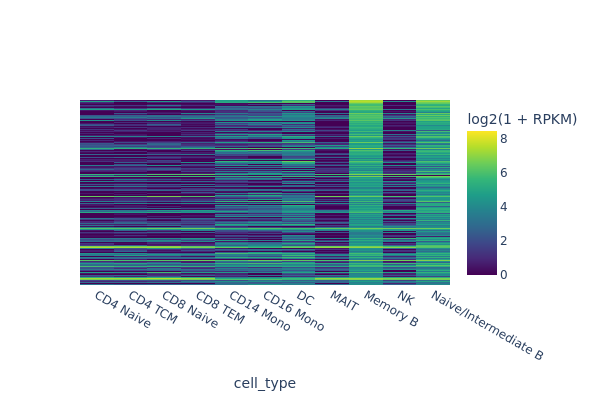

In [18]:
snap.pl.regions(
    peak_mat,
    groupby = 'cell_type',
    peaks = {
        group2: diff_peaks['feature name'].to_numpy(),
    },
    interactive = False,
)

## To Be Continued ...